In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2, VGG16, ResNetRS101
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
import matplotlib
import sklearn
import pip
import wheel

print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)
print("OpenCV version:", cv.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("Keras version:", tf.keras.__version__)
print("Sklearn version:", sklearn.__version__)
print("Pip version:", pip.__version__)
print("Python version:", os.sys.version)
print("Wheel version:", wheel.__version__)

TensorFlow version: 2.10.0
NumPy version: 1.24.4
OpenCV version: 4.11.0
Matplotlib version: 3.7.5
Seaborn version: 0.13.2
Keras version: 2.10.0
Sklearn version: 1.3.2
Pip version: 25.0.1
Python version: 3.8.0 (tags/v3.8.0:fa919fd, Oct 14 2019, 19:37:50) [MSC v.1916 64 bit (AMD64)]
Wheel version: 0.45.1


In [20]:
# Parámetros
dataset_dir = "C:\\Users\\Dragut\\Desktop\\bobio\\Samsung\\PF\\Data_set"
batch_size = 32
img_size = (224, 224)  # Ajusta el tamaño deseado
validation_split = 0.2  # 20% de los datos para validación
seed = 123  # Semilla para reproducibilidad

# Carga del dataset para entrenamiento
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",        # Usamos la parte de entrenamiento
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",  # O 'int' según tus necesidades
    shuffle=True
)

# Carga del dataset para validación
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",      # Usamos la parte de validación
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

# Verificar etiquetas asignadas
class_names = train_ds.class_names  # Debería mostrar ['cats', 'dogs']
print("Clases asignadas:", class_names)

# Verificar tamaños de los datasets
train_size = tf.data.experimental.cardinality(train_ds).numpy()
val_size = tf.data.experimental.cardinality(val_ds).numpy()

print(f"Entrenamiento: {train_size} batches")
print(f"Validación: {val_size} batches")

# Función para normalizar las imágenes
def normalize_img(image, label):
    image = tf.image.rgb_to_grayscale(image)
    # image = tf.image.grayscale_to_rgb(image)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Aplicar la normalización a los datasets
train_ds = train_ds.map(normalize_img)
val_ds = val_ds.map(normalize_img)

Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.
Clases asignadas: ['lung_adenocarcinoma', 'lung_benigno', 'lung_carcinoma']
Entrenamiento: 375 batches
Validación: 94 batches


# MobileNetV2

In [12]:
input_shape = (224, 224, 3)
num_classes = 3

In [4]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(3, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'], loss="categorical_crossentropy")

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [14]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitorea la pérdida de validación
    patience=5,               # Si no mejora en 5 épocas consecutivas, se detiene
    restore_best_weights=True # Restaura los mejores pesos durante el entrenamiento
)

with tf.device('/GPU:0'):
    history = model.fit(train_ds, 
                        validation_data=val_ds.take(int(tf.data.experimental.cardinality(val_ds).numpy() * 0.2)), 
                        epochs=50, 
                        callbacks=[early_stopping])

Epoch 1/50
375/375 [==============================] - 25s 56ms/step - loss: 0.2699 - accuracy: 0.8899 - val_loss: 0.1174 - val_accuracy: 0.9549
Epoch 2/50
375/375 [==============================] - 21s 55ms/step - loss: 0.1331 - accuracy: 0.9481 - val_loss: 0.0974 - val_accuracy: 0.9670
Epoch 3/50
375/375 [==============================] - 20s 54ms/step - loss: 0.0971 - accuracy: 0.9619 - val_loss: 0.0639 - val_accuracy: 0.9757
Epoch 4/50
375/375 [==============================] - 20s 54ms/step - loss: 0.0754 - accuracy: 0.9702 - val_loss: 0.0538 - val_accuracy: 0.9757
Epoch 5/50
375/375 [==============================] - 21s 54ms/step - loss: 0.0571 - accuracy: 0.9783 - val_loss: 0.0487 - val_accuracy: 0.9809
Epoch 6/50
375/375 [==============================] - 21s 54ms/step - loss: 0.0488 - accuracy: 0.9824 - val_loss: 0.0443 - val_accuracy: 0.9809
Epoch 7/50
375/375 [==============================] - 21s 54ms/step - loss: 0.0433 - accuracy: 0.9842 - val_loss: 0.0357 - val_accuracy:

In [17]:
#Evaluamos el modelo
loss, accuracy = model.evaluate(val_ds)
print(f"Accuracy: {accuracy}")

94/94 [==============================] - 6s 54ms/step - loss: 0.0142 - accuracy: 0.9940
Accuracy: 0.9940000176429749


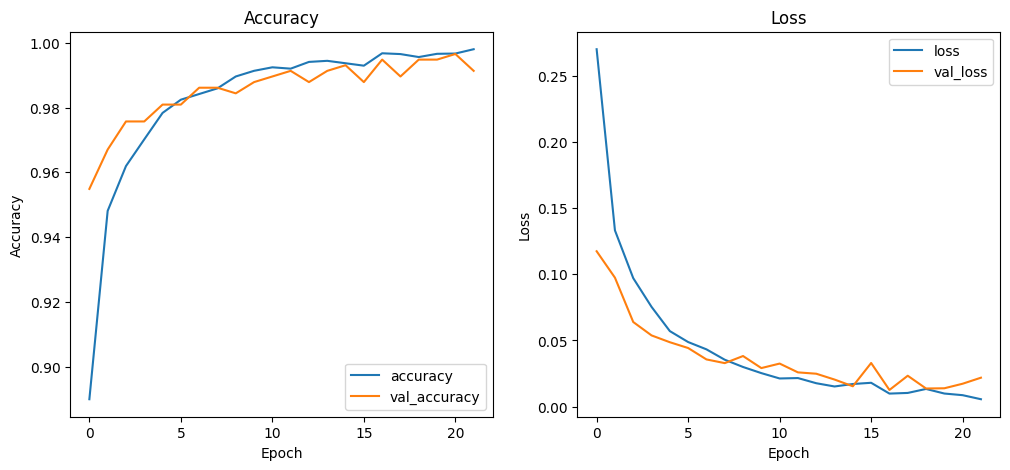

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [9]:
# Crear las listas de etiquetas verdaderas y predicciones
y_true_list = []
y_pred_list = []

for images, labels in val_ds:
    y_true_list.append(labels.numpy())  # Convertimos las etiquetas a numpy
    y_pred_probs = model.predict(images)  # Predecimos las probabilidades
    y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convertimos las probabilidades a 0 o 1
    y_pred_list.append(y_pred_labels)  # Guardamos las predy_test_clases = np.argmax(y_true, axis=1)icciones

# Unir las listas de etiquetas verdaderas y predicciones
y_true = np.concatenate(y_true_list)
y_test_clases = np.argmax(y_true, axis=1)
y_pred = np.concatenate(y_pred_list)

1/1 [==============================] - 0s 450ms/step


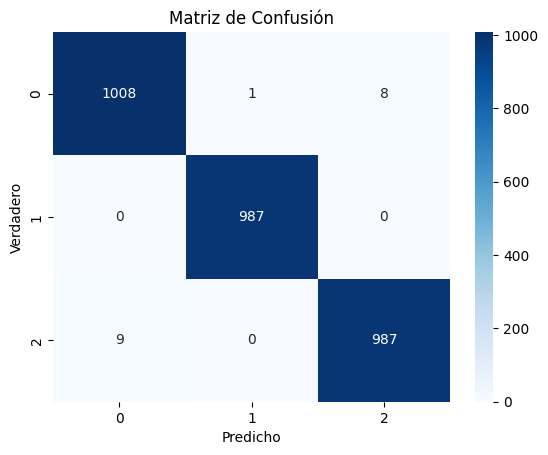

In [20]:
# Crear la matriz de confusión
cm = confusion_matrix(y_test_clases, y_pred)

# Visualizarla con seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

In [10]:
print(classification_report(y_test_clases, y_pred, target_names=class_names))

                     precision    recall  f1-score   support

lung_adenocarcinoma       0.99      0.99      0.99      1017
       lung_benigno       1.00      1.00      1.00       987
     lung_carcinoma       0.99      0.99      0.99       996

           accuracy                           0.99      3000
          macro avg       0.99      0.99      0.99      3000
       weighted avg       0.99      0.99      0.99      3000



# VGG

In [7]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(3, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'], loss="categorical_crossentropy")

In [8]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [16]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitorea la pérdida de validación
    patience=5,               # Si no mejora en 5 épocas consecutivas, se detiene
    restore_best_weights=True # Restaura los mejores pesos durante el entrenamiento
)

with tf.device('/GPU:0'):
    history = model.fit(train_ds, 
                        validation_data=val_ds.take(int(tf.data.experimental.cardinality(val_ds).numpy() * 0.2)), 
                        epochs=50, 
                        callbacks=[early_stopping])

Epoch 1/50
375/375 [==============================] - 66s 166ms/step - loss: 0.5137 - accuracy: 0.7822 - val_loss: 0.2574 - val_accuracy: 0.9028
Epoch 2/50
375/375 [==============================] - 64s 169ms/step - loss: 0.2600 - accuracy: 0.8965 - val_loss: 0.2378 - val_accuracy: 0.8924
Epoch 3/50
375/375 [==============================] - 64s 170ms/step - loss: 0.2219 - accuracy: 0.9134 - val_loss: 0.2032 - val_accuracy: 0.9167
Epoch 4/50
375/375 [==============================] - 64s 171ms/step - loss: 0.2046 - accuracy: 0.9182 - val_loss: 0.2154 - val_accuracy: 0.9219
Epoch 5/50
375/375 [==============================] - 64s 171ms/step - loss: 0.1893 - accuracy: 0.9269 - val_loss: 0.2014 - val_accuracy: 0.9184
Epoch 6/50
375/375 [==============================] - 64s 169ms/step - loss: 0.1747 - accuracy: 0.9326 - val_loss: 0.2010 - val_accuracy: 0.9132
Epoch 7/50
375/375 [==============================] - 64s 171ms/step - loss: 0.1716 - accuracy: 0.9333 - val_loss: 0.1678 - val_ac

In [17]:
#Evaluamos el modelo
loss, accuracy = model.evaluate(val_ds)
print(f"Accuracy: {accuracy}")

94/94 [==============================] - 18s 185ms/step - loss: 0.0832 - accuracy: 0.9660
Accuracy: 0.9660000205039978


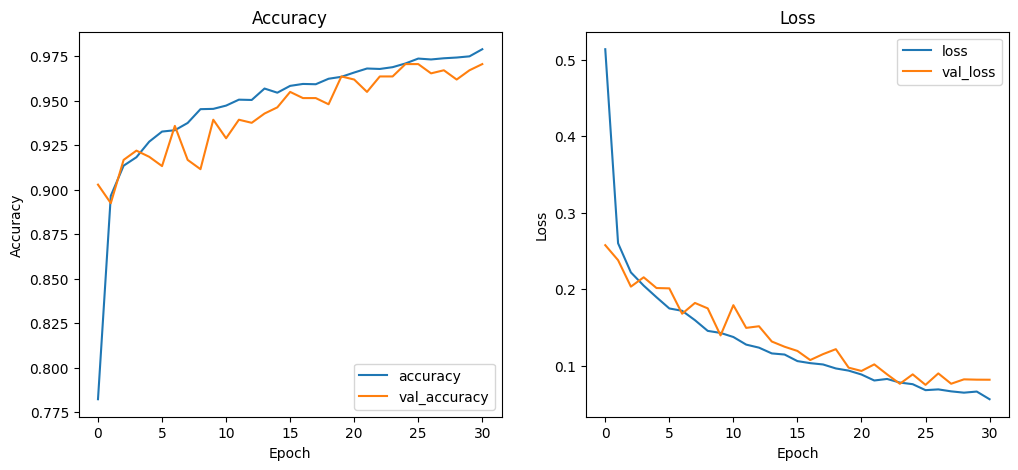

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [19]:
# Crear las listas de etiquetas verdaderas y predicciones
y_true_list = []
y_pred_list = []

for images, labels in val_ds:
    y_true_list.append(labels.numpy())  # Convertimos las etiquetas a numpy
    y_pred_probs = model.predict(images)  # Predecimos las probabilidades
    y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convertimos las probabilidades a 0 o 1
    y_pred_list.append(y_pred_labels)  # Guardamos las predy_test_clases = np.argmax(y_true, axis=1)icciones

# Unir las listas de etiquetas verdaderas y predicciones
y_true = np.concatenate(y_true_list)
y_test_clases = np.argmax(y_true, axis=1)
y_pred = np.concatenate(y_pred_list)

1/1 [==============================] - 0s 100ms/step


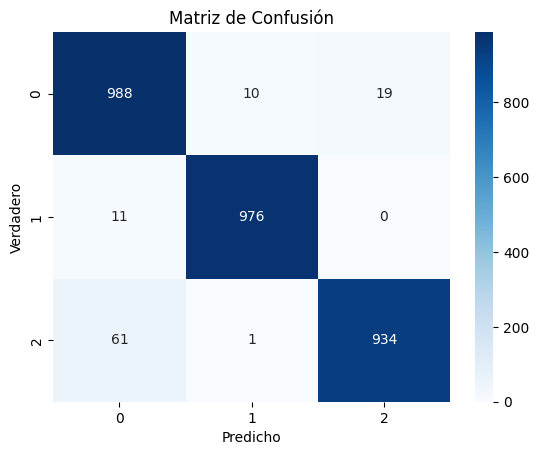

In [20]:
# Crear la matriz de confusión
cm = confusion_matrix(y_test_clases, y_pred)

# Visualizarla con seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

In [21]:
print(classification_report(y_test_clases, y_pred, target_names=class_names))

                     precision    recall  f1-score   support

lung_adenocarcinoma       0.93      0.97      0.95      1017
       lung_benigno       0.99      0.99      0.99       987
     lung_carcinoma       0.98      0.94      0.96       996

           accuracy                           0.97      3000
          macro avg       0.97      0.97      0.97      3000
       weighted avg       0.97      0.97      0.97      3000



# ResNetRS101

In [10]:
base_model = ResNetRS101(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(3, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'], loss="categorical_crossentropy")

In [11]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 226, 226, 3)  0          ['normalization[0][0]']    

In [42]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitorea la pérdida de validación
    patience=5,               # Si no mejora en 5 épocas consecutivas, se detiene
    restore_best_weights=True # Restaura los mejores pesos durante el entrenamiento
)

with tf.device('/GPU:0'):
    history = model.fit(train_ds, 
                        validation_data=val_ds.take(int(tf.data.experimental.cardinality(val_ds).numpy() * 0.2)), 
                        epochs=50, 
                        callbacks=[early_stopping])

Epoch 1/50
375/375 [==============================] - 88s 219ms/step - loss: 1.0704 - accuracy: 0.4179 - val_loss: 1.0207 - val_accuracy: 0.4670
Epoch 2/50
375/375 [==============================] - 81s 215ms/step - loss: 1.0366 - accuracy: 0.4657 - val_loss: 1.0198 - val_accuracy: 0.4913
Epoch 3/50
375/375 [==============================] - 81s 216ms/step - loss: 1.0200 - accuracy: 0.4816 - val_loss: 1.0047 - val_accuracy: 0.5122
Epoch 4/50
375/375 [==============================] - 81s 215ms/step - loss: 1.0065 - accuracy: 0.4901 - val_loss: 0.9784 - val_accuracy: 0.5174
Epoch 5/50
375/375 [==============================] - 81s 215ms/step - loss: 0.9937 - accuracy: 0.5023 - val_loss: 0.9512 - val_accuracy: 0.5312
Epoch 6/50
375/375 [==============================] - 80s 213ms/step - loss: 0.9827 - accuracy: 0.5074 - val_loss: 0.9736 - val_accuracy: 0.5243
Epoch 7/50
375/375 [==============================] - 80s 214ms/step - loss: 0.9736 - accuracy: 0.5173 - val_loss: 0.9321 - val_ac

In [43]:
#Evaluamos el modelo
loss, accuracy = model.evaluate(val_ds)
print(f"Accuracy: {accuracy}")

94/94 [==============================] - 21s 215ms/step - loss: 0.8027 - accuracy: 0.6293
Accuracy: 0.6293333172798157


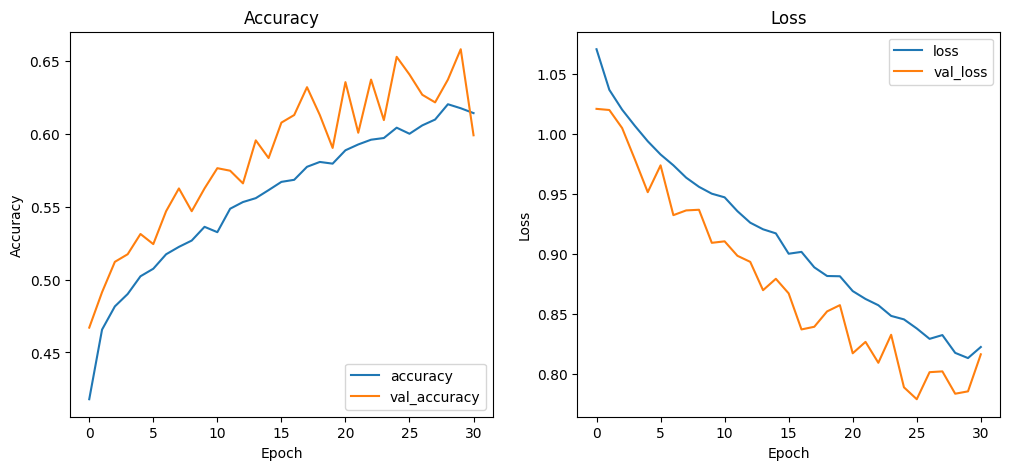

In [44]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [26]:
# Crear las listas de etiquetas verdaderas y predicciones
y_true_list = []
y_pred_list = []

for images, labels in val_ds:
    y_true_list.append(labels.numpy())  # Convertimos las etiquetas a numpy
    y_pred_probs = model.predict(images)  # Predecimos las probabilidades
    y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convertimos las probabilidades a 0 o 1
    y_pred_list.append(y_pred_labels)  # Guardamos las predy_test_clases = np.argmax(y_true, axis=1)icciones

# Unir las listas de etiquetas verdaderas y predicciones
y_true = np.concatenate(y_true_list)
y_test_clases = np.argmax(y_true, axis=1)
y_pred = np.concatenate(y_pred_list)

1/1 [==============================] - 1s 1s/step


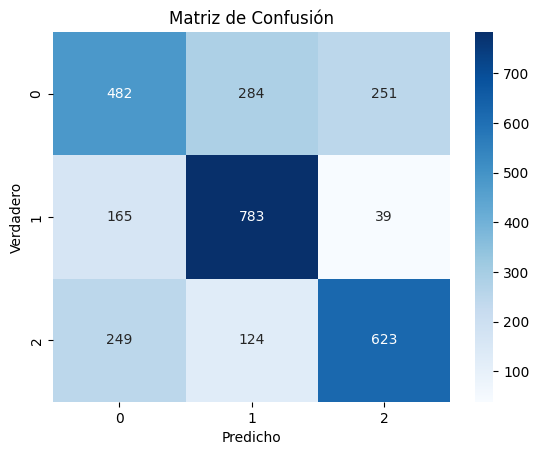

In [46]:
# Crear la matriz de confusión
cm = confusion_matrix(y_test_clases, y_pred)

# Visualizarla con seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

In [27]:
print(classification_report(y_test_clases, y_pred, target_names=class_names))

                     precision    recall  f1-score   support

lung_adenocarcinoma       0.54      0.47      0.50      1017
       lung_benigno       0.66      0.79      0.72       987
     lung_carcinoma       0.68      0.63      0.65       996

           accuracy                           0.63      3000
          macro avg       0.63      0.63      0.63      3000
       weighted avg       0.63      0.63      0.62      3000



# ResNet101 con últimas 20 capas descongeladas

In [13]:
base_model = ResNetRS101(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False
    
for layer in base_model.layers[-20:]:
    layer.trainable = True

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(3, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'], loss="categorical_crossentropy")

In [14]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  0          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [40]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitorea la pérdida de validación
    patience=5,               # Si no mejora en 5 épocas consecutivas, se detiene
    restore_best_weights=True # Restaura los mejores pesos durante el entrenamiento
)

with tf.device('/GPU:0'):
    history = model.fit(train_ds, 
                        validation_data=val_ds.take(int(tf.data.experimental.cardinality(val_ds).numpy() * 0.2)), 
                        epochs=50, 
                        callbacks=[early_stopping])

Epoch 1/50
375/375 [==============================] - 94s 232ms/step - loss: 0.9642 - accuracy: 0.5163 - val_loss: 0.8397 - val_accuracy: 0.5799
Epoch 2/50
375/375 [==============================] - 87s 231ms/step - loss: 0.7589 - accuracy: 0.6468 - val_loss: 0.6972 - val_accuracy: 0.6806
Epoch 3/50
375/375 [==============================] - 85s 227ms/step - loss: 0.6810 - accuracy: 0.6861 - val_loss: 0.8832 - val_accuracy: 0.5920
Epoch 4/50
375/375 [==============================] - 86s 228ms/step - loss: 0.6427 - accuracy: 0.7071 - val_loss: 0.5500 - val_accuracy: 0.7483
Epoch 5/50
375/375 [==============================] - 87s 231ms/step - loss: 0.6157 - accuracy: 0.7200 - val_loss: 0.7664 - val_accuracy: 0.6615
Epoch 6/50
375/375 [==============================] - 87s 231ms/step - loss: 0.5852 - accuracy: 0.7351 - val_loss: 0.5504 - val_accuracy: 0.7517
Epoch 7/50
375/375 [==============================] - 87s 233ms/step - loss: 0.5703 - accuracy: 0.7459 - val_loss: 0.7728 - val_ac

In [41]:
#Evaluamos el modelo
loss, accuracy = model.evaluate(val_ds)
print(f"Accuracy: {accuracy}")

94/94 [==============================] - 20s 207ms/step - loss: 0.6019 - accuracy: 0.7237
Accuracy: 0.7236666679382324


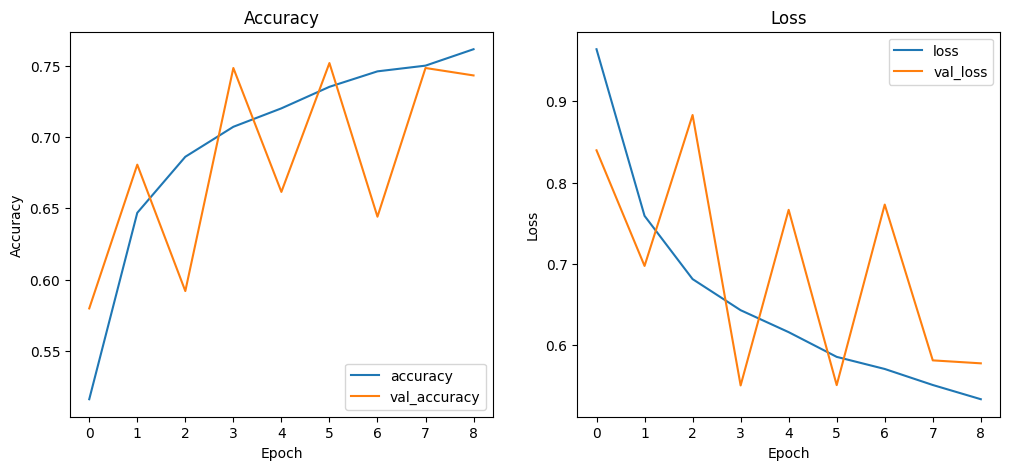

In [42]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [43]:
# Crear las listas de etiquetas verdaderas y predicciones
y_true_list = []
y_pred_list = []

for images, labels in val_ds:
    y_true_list.append(labels.numpy())  # Convertimos las etiquetas a numpy
    y_pred_probs = model.predict(images)  # Predecimos las probabilidades
    y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convertimos las probabilidades a 0 o 1
    y_pred_list.append(y_pred_labels)  # Guardamos las predy_test_clases = np.argmax(y_true, axis=1)icciones

# Unir las listas de etiquetas verdaderas y predicciones
y_true = np.concatenate(y_true_list)
y_test_clases = np.argmax(y_true, axis=1)
y_pred = np.concatenate(y_pred_list)

1/1 [==============================] - 1s 1s/step


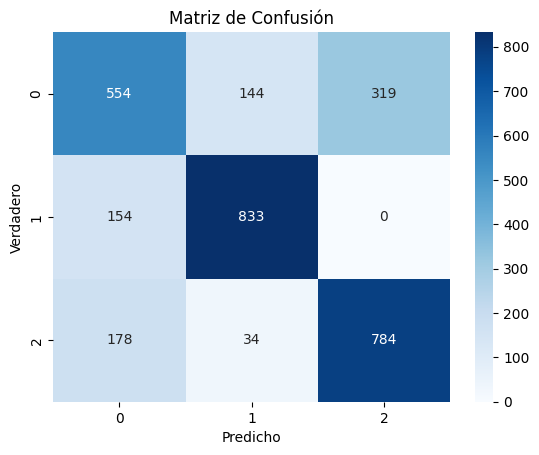

In [44]:
# Crear la matriz de confusión
cm = confusion_matrix(y_test_clases, y_pred)

# Visualizarla con seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

In [45]:
print(classification_report(y_test_clases, y_pred, target_names=class_names))

                     precision    recall  f1-score   support

lung_adenocarcinoma       0.63      0.54      0.58      1017
       lung_benigno       0.82      0.84      0.83       987
     lung_carcinoma       0.71      0.79      0.75       996

           accuracy                           0.72      3000
          macro avg       0.72      0.73      0.72      3000
       weighted avg       0.72      0.72      0.72      3000



# Propuesta de CNN

In [33]:
#Propuesta de CNN

model = models.Sequential([
    
    #Primera capa
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", input_shape=(224, 224, 1)),
    layers.MaxPooling2D((2,2)),
    
    #Segunda capa
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    
    #Tercera capa
    layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    
    #Aplanamiento y conexión con capa densa
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(3, activation="softmax")
])

model.compile(optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"], loss="categorical_crossentropy")

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 64)      640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 256)       295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 256)     

In [24]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitorea la pérdida de validación
    patience = 5,               # Si no mejora en 5 épocas consecutivas, se detiene
    restore_best_weights=True # Restaura los mejores pesos durante el entrenamiento
)

with tf.device('/GPU:0'):
    history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stopping])

Epoch 1/50
375/375 [==============================] - 45s 118ms/step - loss: 0.9564 - accuracy: 0.4960 - val_loss: 0.6512 - val_accuracy: 0.6930
Epoch 2/50
375/375 [==============================] - 44s 118ms/step - loss: 0.6543 - accuracy: 0.7118 - val_loss: 0.4949 - val_accuracy: 0.7827
Epoch 3/50
375/375 [==============================] - 44s 118ms/step - loss: 0.5562 - accuracy: 0.7692 - val_loss: 0.3894 - val_accuracy: 0.8550
Epoch 4/50
375/375 [==============================] - 45s 120ms/step - loss: 0.4827 - accuracy: 0.8042 - val_loss: 0.3540 - val_accuracy: 0.8727
Epoch 5/50
375/375 [==============================] - 45s 119ms/step - loss: 0.4277 - accuracy: 0.8351 - val_loss: 0.3952 - val_accuracy: 0.8393
Epoch 6/50
375/375 [==============================] - 46s 121ms/step - loss: 0.3595 - accuracy: 0.8655 - val_loss: 0.3000 - val_accuracy: 0.8813
Epoch 7/50
375/375 [==============================] - 46s 123ms/step - loss: 0.3299 - accuracy: 0.8783 - val_loss: 0.2763 - val_ac

In [25]:
#Evaluamos el modelo
loss, accuracy = model.evaluate(val_ds)
print(f"Accuracy: {accuracy}")

94/94 [==============================] - 4s 40ms/step - loss: 0.2295 - accuracy: 0.9130
Accuracy: 0.9129999876022339


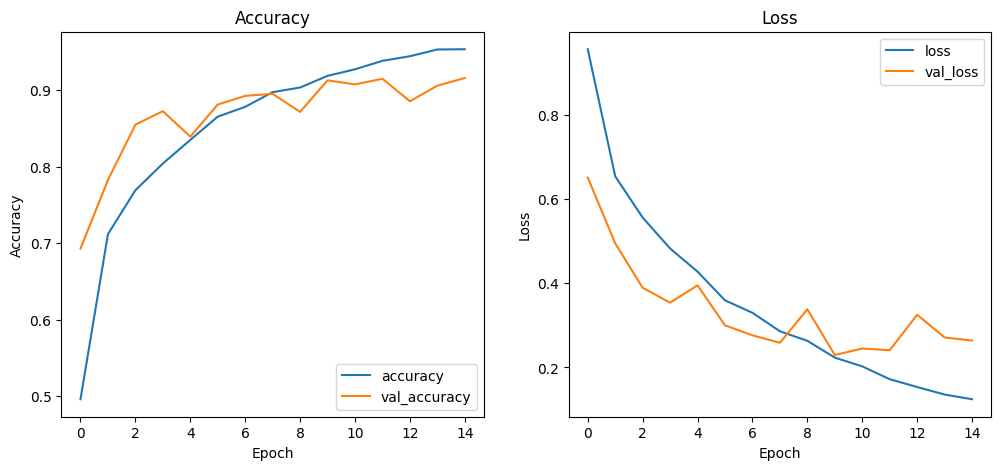

In [26]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [27]:
# Crear las listas de etiquetas verdaderas y predicciones
y_true_list = []
y_pred_list = []

for images, labels in val_ds:
    y_true_list.append(labels.numpy())  # Convertimos las etiquetas a numpy
    y_pred_probs = model.predict(images)  # Predecimos las probabilidades
    y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convertimos las probabilidades a 0 o 1
    y_pred_list.append(y_pred_labels)  # Guardamos las predy_test_clases = np.argmax(y_true, axis=1)icciones

# Unir las listas de etiquetas verdaderas y predicciones
y_true = np.concatenate(y_true_list)
y_test_clases = np.argmax(y_true, axis=1)
y_pred = np.concatenate(y_pred_list)

1/1 [==============================] - 0s 62ms/step


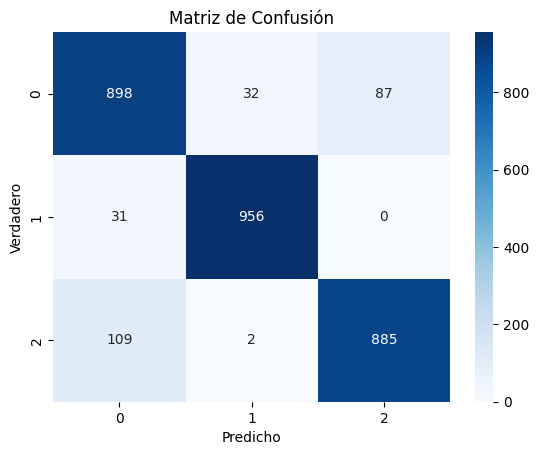

In [28]:
# Crear la matriz de confusión
cm = confusion_matrix(y_test_clases, y_pred)

# Visualizarla con seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.show()

In [29]:
print(classification_report(y_test_clases, y_pred, target_names=class_names))

                     precision    recall  f1-score   support

lung_adenocarcinoma       0.87      0.88      0.87      1017
       lung_benigno       0.97      0.97      0.97       987
     lung_carcinoma       0.91      0.89      0.90       996

           accuracy                           0.91      3000
          macro avg       0.91      0.91      0.91      3000
       weighted avg       0.91      0.91      0.91      3000



In [ ]:
# Cargar la imagen
img_path = "C:\\Users\\Dragut\\Desktop\\bobio\\Samsung\\PF\\Imagenes prueba\\adc4.jpg"  # Ruta de la imagen
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (224, 224))

# Convertir la imagen a un array de numpy
img_array = image.img_to_array(img)

# Normalizar la imagen (MobileNetV2 usa valores entre 0 y 1)
img_array = img_array / 255.0

# Expandir dimensiones para que tenga forma (1, 224, 224, 3)
img_array = np.expand_dims(img_array, axis=0)

# Realizar la predicción
y_pred_probs = model.predict(img_array)  # Salida con probabilidades para cada clase

# Obtener la clase con mayor probabilidad
y_pred_label = np.argmax(y_pred_probs, axis=1)[0]  # 0 = adenocarcinoma, 1 = benigno, 2 = carcinoma

# Diccionario para mapear índices a nombres de clases
class_names = ["pulmon_adenocarcinoma", "pulmon_benigno", "pulmon_carcinoma"]

# Mostrar la clase predicha
print(f"Clase predicha: {class_names[y_pred_label]}")
print(f"Probabilidades: {y_pred_probs[0]}")

1/1 [==============================] - 0s 188ms/step
Clase predicha: pulmon_carcinoma
Probabilidades: [2.0007343e-05 1.1544650e-16 9.9997997e-01]


In [30]:
model.save("C:\\Users\\Dragut\\Desktop\\bobio\\Samsung\\PF\\Modelos\\modelo_propuesto_mayor_complejidad_v2.h5")

In [34]:
del model  # Elimina el modelo de la memoria RAM
tf.keras.backend.clear_session()  # Libera recursos de TensorFlow